In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
!pip install scalecast
from scalecast.Forecaster import Forecaster
from scalecast.MVForecaster import MVForecaster
from scalecast.multiseries import export_model_summaries
from scalecast import GridGenerator

sns.set(rc={'figure.figsize':(12,8)})

c:\Users\mattd\Anaconda3\envs\Mattsenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
c:\Users\mattd\Anaconda3\envs\Mattsenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
!pip install SCALECAST

In [5]:
from scalecast.Forecaster import Forecaster
from scalecast.MVForecaster import MVForecaster
from scalecast.multiseries import export_model_summaries
from scalecast import GridGenerator

c:\Users\mattd\Anaconda3\envs\Mattsenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
c:\Users\mattd\Anaconda3\envs\Mattsenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [66]:
# import the data

data = pd.read_csv(r'C:\Users\mattd\OneDrive\Desktop\Monthly_Flux_Data.csv', parse_dates=['Date'])

In [67]:
data.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)

In [68]:
data.isnull().values.any()

False

In [69]:
# download template validation grids (will not overwrite existing Grids.py file by default)
models = ('mlr','elasticnet','knn','rf','gbt','xgboost','mlp')
GridGenerator.get_example_grids()
GridGenerator.get_mv_grids()

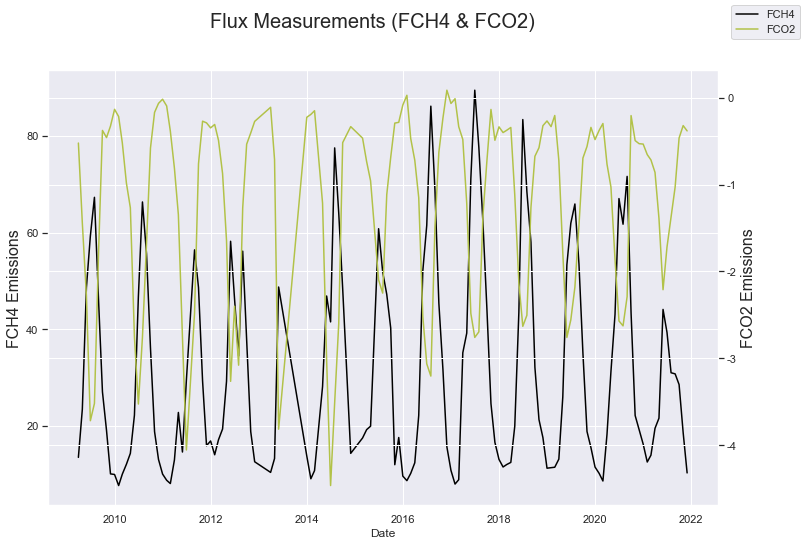

In [70]:
fig, ax = plt.subplots()
sns.lineplot(x='Date',y='FCH4',data=data,label='FCH4',ax=ax,color='black',legend=False)
plt.ylabel('FCH4 Emissions',size=16)
ax2 = ax.twinx()
sns.lineplot(x='Date',y='FCO2',data=data,label='FCO2',ax=ax2,color='#B2C248',legend=False)
ax.figure.legend()
plt.ylabel('FCO2 Emissions',size=16)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax2.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.suptitle('Flux Measurements (FCH4 & FCO2)',size=20)
plt.show()

In [71]:
# Examine Correlation between the series

corr = np.corrcoef(data['FCH4'].values,data['FCO2'].values)[0,1]
print('{:.2%}'.format(corr))

-74.90%


In [72]:
fCH4 = Forecaster(y=data['FCH4'],current_dates = data['Date'])
fCH4

Forecaster(
    DateStartActuals=2009-04-01T00:00:00.000000000
    DateEndActuals=2021-12-01T00:00:00.000000000
    Freq=None
    N_actuals=138
    ForecastLength=0
    Xvars=[]
    Differenced=0
    TestLength=1
    ValidationLength=1
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    BootstrapSamples=100
    CurrentEstimator=None
)

In [73]:
fCO2 = Forecaster(y=data['FCO2'],current_dates = data['Date'])
fCO2

Forecaster(
    DateStartActuals=2009-04-01T00:00:00.000000000
    DateEndActuals=2021-12-01T00:00:00.000000000
    Freq=None
    N_actuals=138
    ForecastLength=0
    Xvars=[]
    Differenced=0
    TestLength=1
    ValidationLength=1
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    BootstrapSamples=100
    CurrentEstimator=None
)

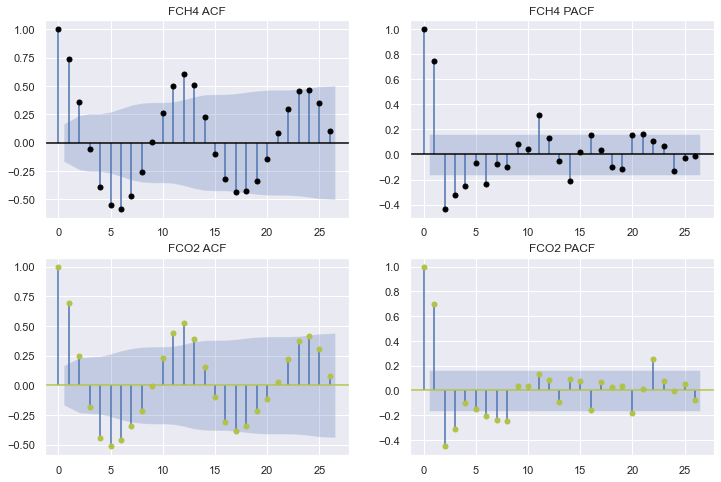

In [74]:
figs, axs = plt.subplots(2, 2)
fCH4.plot_acf(ax=axs[0,0],title='FCH4 ACF',lags=26,color='black')
fCH4.plot_pacf(ax=axs[0,1],title='FCH4 PACF',lags=26,color='black')
fCO2.plot_acf(ax=axs[1,0],title='FCO2 ACF',lags=26,color='#B2C248')
fCO2.plot_pacf(ax=axs[1,1],title='FCO2 PACF',lags=26,color='#B2C248')
plt.show()

The ACF Plot shows which lag points standout - the lag points not included in the blue signficance line differ for FCH4 and FCO2.

In [77]:
# Check Stationarity

critical_pval = 0.05
print('-'*100)
print('FCH4 Augmented Dickey-Fuller results:')
stat, pval, _, _, _, _ = fCH4.adf_test(full_res=True)
print('the test-stat value is: {:.2f}'.format(stat))
print('the p-value is {:.4f}'.format(pval))
print('the series is {}'.format('stationary' if pval < critical_pval else 'not stationary'))
print('-'*100)
print('FCO2 Augmented Dickey-Fuller results:')
stat, pval, _, _, _, _ = fCO2.adf_test(full_res=True)
print('the test-stat value is: {:.2f}'.format(stat))
print('the p-value is {:.4f}'.format(pval))
print('the series is {}'.format('stationary' if pval < critical_pval else 'not stationary'))
print('-'*100)

----------------------------------------------------------------------------------------------------
FCH4 Augmented Dickey-Fuller results:
the test-stat value is: -2.79
the p-value is 0.0603
the series is not stationary
----------------------------------------------------------------------------------------------------
FCO2 Augmented Dickey-Fuller results:
the test-stat value is: -8.26
the p-value is 0.0000
the series is stationary
----------------------------------------------------------------------------------------------------


In [78]:
for f in (fCH4,fCO2):
    f.generate_future_dates(52)
    f.set_test_length(.2)
    f.set_validation_length(4)
    f.add_seasonal_regressors('week','month','quarter',raw=False,sincos=True)
    f.add_seasonal_regressors('year')
    f.add_time_trend()
    f.add_cycle(26)
    f.add_ar_terms(3)

In [79]:
fCH4.tune_test_forecast(models,feature_importance=True)
fCH4.set_estimator('combo')
fCH4.manual_forecast(how='weighted')

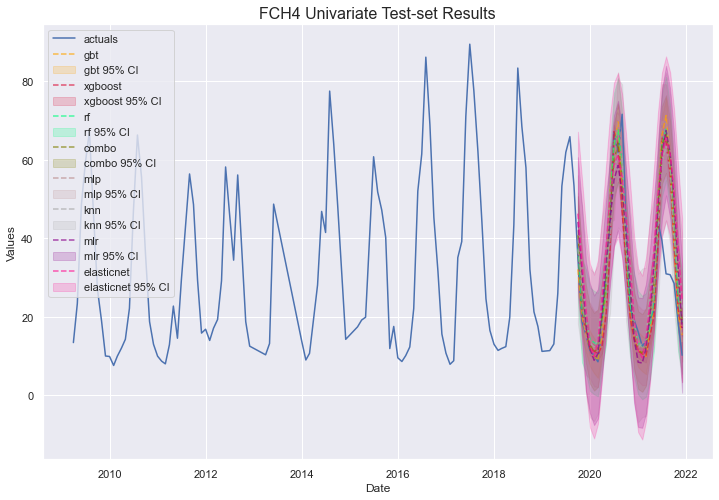

In [80]:
fCH4.plot_test_set(ci=True,order_by='LevelTestSetMAPE')
plt.title('FCH4 Univariate Test-set Results',size=16)
plt.show()

In [81]:
fCO2.tune_test_forecast(models,feature_importance=True)
fCO2.set_estimator('combo')
fCO2.manual_forecast(how='weighted')

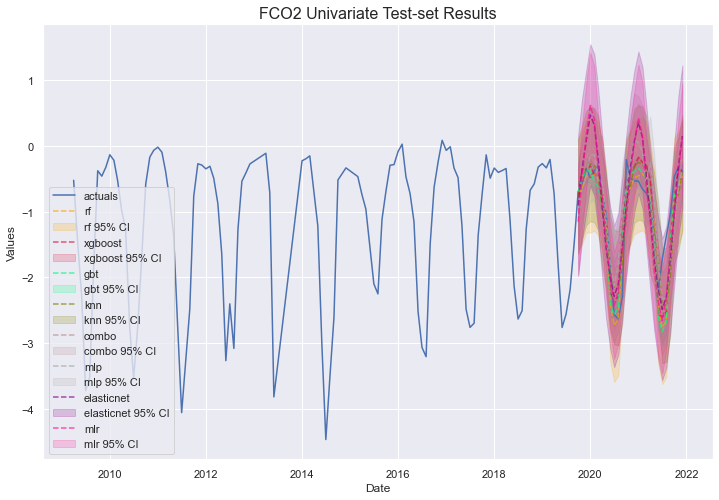

In [82]:
fCO2.plot_test_set(ci=True,order_by='LevelTestSetMAPE')
plt.title('FCO2 Univariate Test-set Results',size=16)
plt.show()

In [83]:
pd.set_option('display.float_format',  '{:.4f}'.format)
ms = export_model_summaries({'FCH4':fCH4,'FCO2':fCO2},determine_best_by='LevelTestSetMAPE')
ms[
    [
        'ModelNickname',
        'Series',
        'Integration',
        'LevelTestSetMAPE',
        'LevelTestSetR2',
        'InSampleMAPE',
        'InSampleR2',
        'best_model'
    ]
]

,ModelNickname,Series,Integration,LevelTestSetMAPE,LevelTestSetR2,InSampleMAPE,InSampleR2,best_model
0,gbt,FCH4,0,0.2401,0.4943,0.0772,0.9848,True
1,xgboost,FCH4,0,0.2697,0.5432,0.0301,0.9985,False
2,rf,FCH4,0,0.2769,0.5536,0.1549,0.9226,False
3,combo,FCH4,0,0.3032,0.5219,0.1564,0.9269,False
4,mlp,FCH4,0,0.3211,0.3763,0.1379,0.9427,False
5,knn,FCH4,0,0.3355,0.5861,0.2867,0.7768,False
6,mlr,FCH4,0,0.3487,0.4234,0.2699,0.8263,False
7,elasticnet,FCH4,0,0.4254,0.3638,0.2793,0.8058,False
8,rf,FCO2,0,0.3766,0.6753,1.2076,0.8396,True
9,xgboost,FCO2,0,0.3816,0.6712,0.0068,1.0000,False


In [84]:
print('-'*100)
for series in ms['Series'].unique():
    print('univariate average test MAPE for {}: {:.4f}'.format(series,ms.loc[ms['Series'] == series,'LevelTestSetMAPE'].mean()))
    print('univariate average test R2 for {}: {:.2f}'.format(series,ms.loc[ms['Series'] == series,'LevelTestSetR2'].mean()))
    print('-'*100)

----------------------------------------------------------------------------------------------------
univariate average test MAPE for FCH4: 0.3151
univariate average test R2 for FCH4: 0.48
----------------------------------------------------------------------------------------------------
univariate average test MAPE for FCO2: 0.5378
univariate average test R2 for FCO2: 0.57
----------------------------------------------------------------------------------------------------


In [85]:
mvf = MVForecaster(fCH4,fCO2,names=['FCH4','FCO2']) # init the mvf object
mvf.set_test_length(.2)
mvf.set_validation_length(4)
mvf

MVForecaster(
    DateStartActuals=2009-04-01T00:00:00.000000000
    DateEndActuals=2021-12-01T00:00:00.000000000
    Freq=None
    N_actuals=138
    N_series=2
    SeriesNames=['FCH4', 'FCO2']
    ForecastLength=52
    Xvars=['weeksin', 'weekcos', 'monthsin', 'monthcos', 'quartersin', 'quartercos', 'year', 't', 'cycle26sin', 'cycle26cos']
    TestLength=27
    ValidationLength=4
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    BootstrapSamples=100
    CurrentEstimator=mlr
    OptimizeOn=mean
)

In [86]:
mvf.corr()

,FCH4,FCO2
FCH4,1.0000,-0.7490
FCO2,-0.7490,1.0000


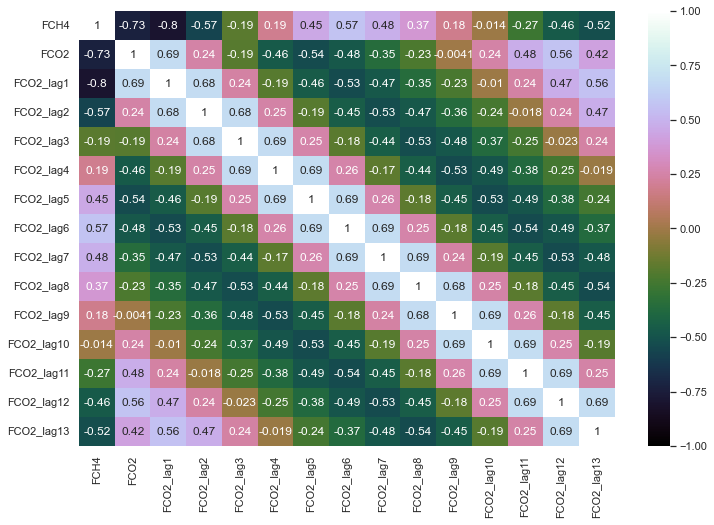

In [87]:
mvf.corr_lags(
    y='FCH4',
    x='FCO2',
    lags=13,
    disp='heatmap',
    annot=True,
    vmin=-1,
    vmax=1,
    cmap = 'cubehelix',
)
plt.show()

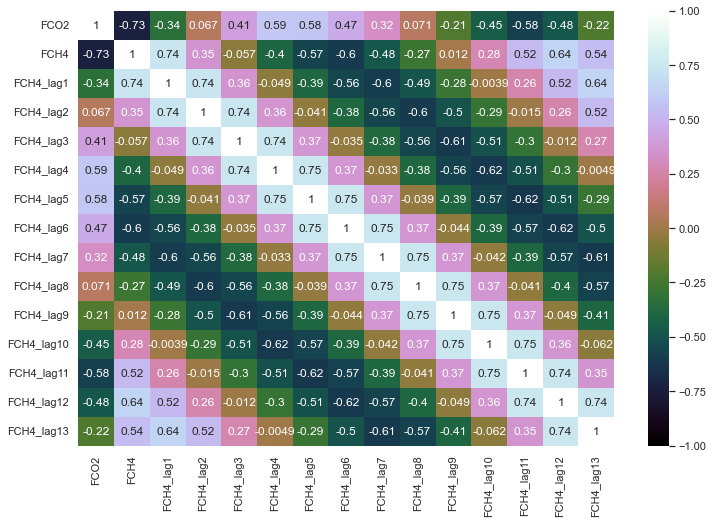

In [88]:
mvf.corr_lags(
    y='FCO2',
    x='FCH4',
    lags=13,
    disp='heatmap',
    annot=True,
    vmin=-1,
    vmax=1,
    cmap = 'cubehelix',
)
plt.show()

In [91]:
# how to optimize on one series
mvf.set_optimize_on('FCH4')
# how to optimize using a weighted avarage
mvf.add_optimizer_func(lambda x: x[0]*.25 + x[1]*.75,'weighted')
mvf.set_optimize_on('weighted')
# how to optimize on the average of both/all series (default)
mvf.set_optimize_on('mean')

In [92]:
mvf.tune_test_forecast(models)
mvf.set_best_model(determine_best_by='LevelTestSetMAPE')

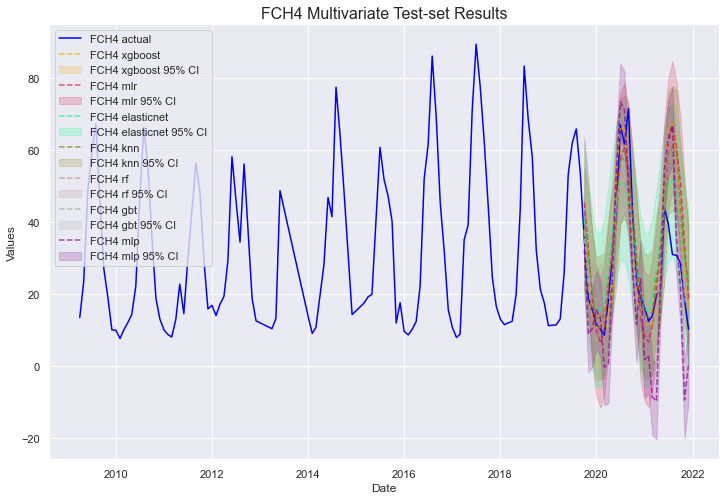

In [93]:
# not plotting both series at the same time because they have significantly different scales
mvf.plot_test_set(series='FCH4',put_best_on_top=True,ci=True)
plt.title('FCH4 Multivariate Test-set Results',size=16)
plt.show()

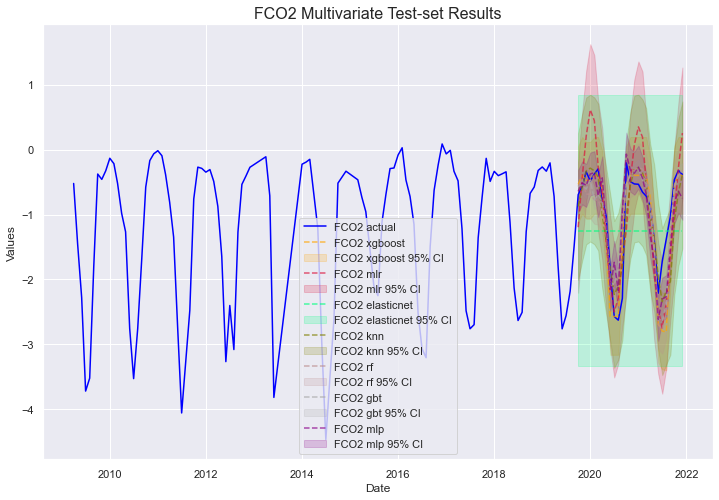

In [94]:
mvf.plot_test_set(series='FCO2',put_best_on_top=True,ci=True)
plt.title('FCO2 Multivariate Test-set Results',size=16)
plt.show()

In [95]:
pd.options.display.max_colwidth = 100
results = mvf.export('model_summaries')
results[
    [
        'ModelNickname',
        'Series',
        'HyperParams',
        'LevelTestSetMAPE',
        'LevelTestSetR2',
        'InSampleMAPE',
        'InSampleR2',
        'Lags'
    ]
]

,ModelNickname,Series,HyperParams,LevelTestSetMAPE,LevelTestSetR2,InSampleMAPE,InSampleR2,Lags
0,xgboost,FCH4,"{'n_estimators': 250, 'scale_pos_weight': 5, 'learning_rate': 0.2, 'gamma': 3, 'subsample': 0.8}",0.2764,0.5099,0.0203,0.9993,6
1,mlr,FCH4,{},0.3859,0.4136,0.2596,0.8354,1
2,elasticnet,FCH4,"{'alpha': 2, 'l1_ratio': 1}",0.3991,0.6027,0.2601,0.8060,1
3,knn,FCH4,{'n_neighbors': 24},0.3445,0.5707,0.2787,0.7822,1
4,rf,FCH4,"{'max_depth': 5, 'n_estimators': 500, 'max_features': 'sqrt', 'max_samples': 0.9}",0.3352,0.5503,0.1517,0.9400,6
5,gbt,FCH4,"{'max_depth': 3, 'max_features': 'sqrt'}",0.3558,0.5618,0.0560,0.9935,6
6,mlp,FCH4,"{'activation': 'relu', 'hidden_layer_sizes': (25,), 'solver': 'lbfgs'}",0.5709,0.2088,0.1511,0.9464,1
7,xgboost,FCO2,"{'n_estimators': 250, 'scale_pos_weight': 5, 'learning_rate': 0.2, 'gamma': 3, 'subsample': 0.8}",0.3249,0.6101,1.1419,0.8866,6
8,mlr,FCO2,{},0.8575,0.3398,0.6631,0.8075,1
9,elasticnet,FCO2,"{'alpha': 2, 'l1_ratio': 1}",1.2545,-0.1264,3.4565,0.0000,1


In [110]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor


estimators = [
    ('mlr',LinearRegression()),
    ('elasticnet',ElasticNet(**results.loc[results['ModelNickname'] == 'elasticnet','HyperParams'].values[0])),
    ('xgboost',XGBRegressor(**results.loc[results['ModelNickname'] == 'xgboost','HyperParams'].values[0]))
]

final_estimator = KNeighborsRegressor(**results.loc[results['ModelNickname'] == 'knn','HyperParams'].values[0])

In [111]:
mvf.add_sklearn_estimator(StackingRegressor,'stacking')
mvf.set_estimator('stacking')
mvf.manual_forecast(estimators=estimators,final_estimator=final_estimator,lags=13)

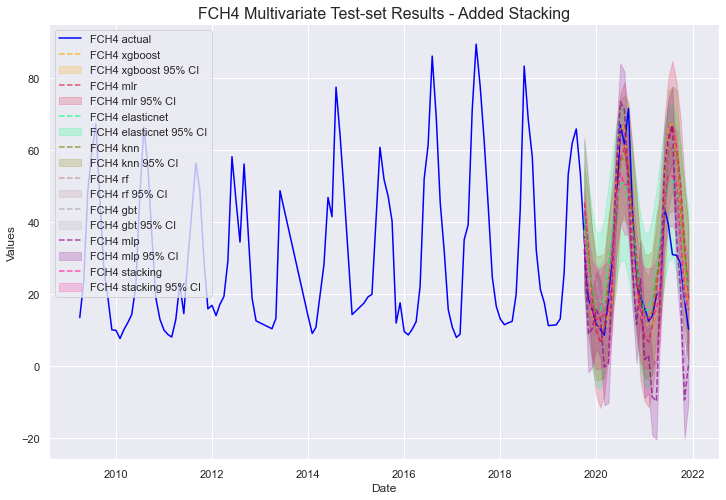

In [112]:
mvf.plot_test_set(series='FCH4',put_best_on_top=True,ci=True)
plt.title('FCH4 Multivariate Test-set Results - Added Stacking',size=16)
plt.show()

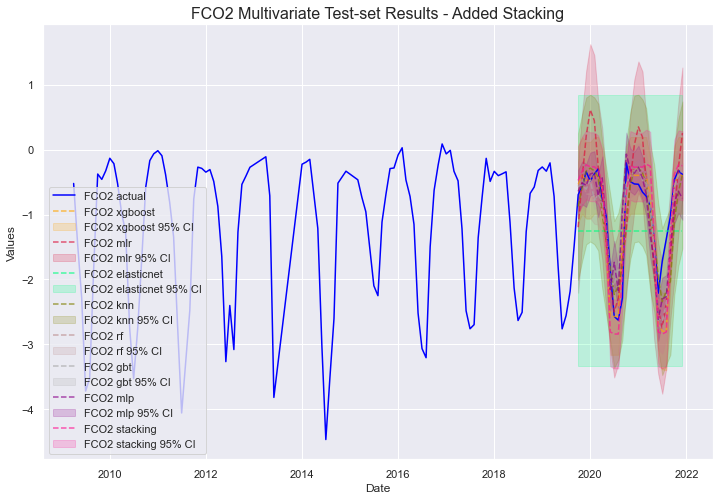

In [113]:
mvf.plot_test_set(series='FCO2',put_best_on_top=True,ci=True)
plt.title('FCO2 Multivariate Test-set Results - Added Stacking',size=16)
plt.show()

In [114]:
mvf.set_best_model(determine_best_by='LevelTestSetMAPE')
results2 = mvf.export('model_summaries')
results2[
    [
        'ModelNickname',
        'Series',
        'LevelTestSetMAPE',
        'LevelTestSetR2',
        'InSampleMAPE',
        'InSampleR2',
        'Lags',
        'best_model'
    ]
]

,ModelNickname,Series,LevelTestSetMAPE,LevelTestSetR2,InSampleMAPE,InSampleR2,Lags,best_model
0,xgboost,FCH4,0.2764,0.5099,0.0203,0.9993,6,True
1,mlr,FCH4,0.3859,0.4136,0.2596,0.8354,1,False
2,elasticnet,FCH4,0.3991,0.6027,0.2601,0.8060,1,False
3,knn,FCH4,0.3445,0.5707,0.2787,0.7822,1,False
4,rf,FCH4,0.3352,0.5503,0.1517,0.9400,6,False
5,gbt,FCH4,0.3558,0.5618,0.0560,0.9935,6,False
6,mlp,FCH4,0.5709,0.2088,0.1511,0.9464,1,False
7,stacking,FCH4,0.2229,0.7291,0.1897,0.8857,13,False
8,xgboost,FCO2,0.3249,0.6101,1.1419,0.8866,6,True
9,mlr,FCO2,0.8575,0.3398,0.6631,0.8075,1,False


In [115]:
print('-'*100)
for series in results2['Series'].unique():
    print('multivariate average test MAPE for {}: {:.4f}'.format(series,results2.loc[results2['Series'] == series,'LevelTestSetMAPE'].mean()))
    print('multivariate average test R2 for {}: {:.2f}'.format(series,results2.loc[results2['Series'] == series,'LevelTestSetR2'].mean()))
    print('-'*100)

----------------------------------------------------------------------------------------------------
multivariate average test MAPE for FCH4: 0.3613
multivariate average test R2 for FCH4: 0.52
----------------------------------------------------------------------------------------------------
multivariate average test MAPE for FCO2: 0.5788
multivariate average test R2 for FCO2: 0.49
----------------------------------------------------------------------------------------------------


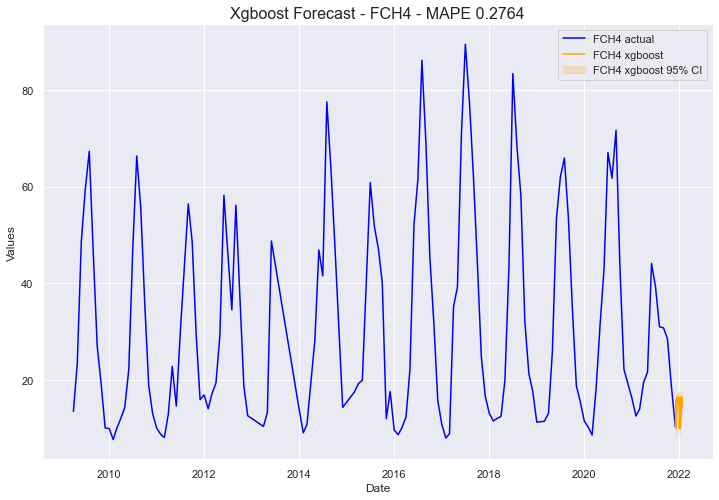

In [116]:
mvf.plot(series='FCH4',models='xgboost',ci=True)
plt.title('Xgboost Forecast - FCH4 - MAPE 0.2764',size=16)
plt.show()

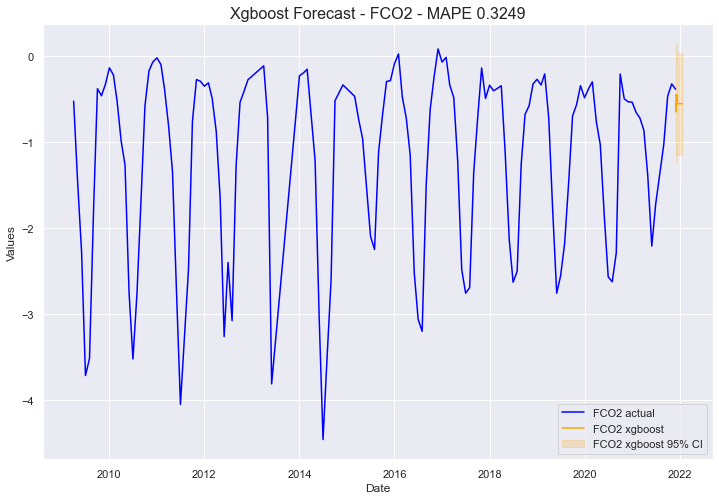

In [107]:
mvf.plot(series='FCO2',models='xgboost',ci=True)
plt.title('Xgboost Forecast - FCO2 - MAPE 0.3249',size=16)
plt.show()